In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
exit(0)
# opencv is pre-installed on colab

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
import torch

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog



def load_dataset(file):
  count = {0:0, 1:0, 2:0, 3:0 }

  dataset = []
  with open(file) as f:

    lines = f.readlines()
    for i, data in enumerate(lines):
      data =  data.rstrip().split('.png')
      path = data[0]
      ann_data = data[1][1:].split("|")
      record = {}
      record['file_name'] = path+".png"
      record['image_id'] = i
      record['height'] = 512
      record['width'] = 512
      record['annotations'] = []
      for ann in ann_data:
        try:
          ann = ann.split(',')
          poly = ann[:-1]
          label = int(ann[-1])

          if label == 0: 
            continue

          count[label] += 1

          x_vals = [float(x) for x in poly[::2]]
          y_vals = [float(x) for x in poly[1::2]]
          polygon = [[float(p) for p in poly]]
          record['annotations'].append(
            {
              "bbox": [np.min(x_vals), np.min(y_vals), np.max(x_vals), np.max(y_vals)],
              "bbox_mode": BoxMode.XYXY_ABS,
              "segmentation": [polygon],
              "category_id": label
            }
          )
        except:
          continue
      if len(record['annotations']) != 0:
          dataset.append(record)
  print(file)
  print(count)
  print(f"{sum(count.values())} total tumours.")
  print("\n")
  return dataset

In [ ]:
DatasetCatalog.clear()

DatasetCatalog.register('train', lambda: load_dataset('/content/drive/MyDrive/DeepTumour/training/train.txt'))
DatasetCatalog.register('test', lambda: load_dataset('/content/drive/MyDrive/DeepTumour/training/test.txt'))

metadata = MetadataCatalog.get("train")
metadata_test = MetadataCatalog.get("test")

metadata.set(thing_classes=['Tumour'])
metadata_test.set(thing_classes=['Tumour'])
dataset_dicts = load_dataset('/content/drive/MyDrive/DeepTumour/training/test.txt')


print(metadata_test)

/content/drive/MyDrive/DeepTumour/training/test.txt
{0: 0, 1: 346, 2: 669, 3: 54}
1069 total tumours.


Metadata(name='test', thing_classes=['Tumour'])


In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
# COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train",)
cfg.DATALOADER.NUM_WORKERS = 0
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.DATASETS.TEST = ("test",) 
cfg.SOLVER.BASE_LR = 1e-3           # Base learning rate
cfg.SOLVER.GAMMA = 0.5              # Learning rate decay
cfg.SOLVER.STEPS = list(range(250, 2000, 250))  # Iterations at which to decay learning rate
cfg.SOLVER.MAX_ITER = 2000          # Maximum number of iterations
cfg.SOLVER.WARMUP_ITERS = 100 
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 4096   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

  cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/Models/catOne.pth'
  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4  # set a custom testing threshold
  predictor = DefaultPredictor(cfg)

cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/Models/catTwo.pth'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6  # set a custom testing threshold
predictor2 = DefaultPredictor(cfg)

cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/Models/catThree.pth'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9  # set a custom testing threshold
predictor3 = DefaultPredictor(cfg)

In [ ]:
def bb_intersection_over_union(truth, pred):
  # Max Pair
	x_max = max(truth[0], pred[0])
	y_max = max(truth[1], pred[1])
 
  # Min Pair
	x_min = min(truth[2], pred[2])
	y_min = min(truth[3], pred[3])
 
	interArea = max(0, x_min - x_max + 1) * max(0, y_min - y_max + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	truth_area = (truth[2] - truth[0] + 1) * (truth[3] - truth[1] + 1)
	pred_area = (pred[2] - pred[0] + 1) * (pred[3] - pred[1] + 1)
 
	# compute the intersection over union by taking the intersection
	iou = interArea / float(truth_area + pred_area - interArea)

	return iou


/content/drive/MyDrive/DeepTumour/training/test.txt
{0: 0, 1: 346, 2: 669, 3: 54}
1069 total tumours.


{'file_name': '/content/drive/My Drive/DeepTumour/pre-processing/data/Image/LIDC-IDRI-0420/LIDC-IDRI-0420_slice_82.png', 'image_id': 699, 'height': 512, 'width': 512, 'annotations': [{'bbox': [140.0, 70.0, 153.0, 86.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[[148.0, 70.0, 147.0, 71.0, 146.0, 71.0, 145.0, 72.0, 144.0, 73.0, 143.0, 73.0, 142.0, 73.0, 141.0, 74.0, 140.0, 75.0, 141.0, 76.0, 141.0, 77.0, 142.0, 78.0, 142.0, 79.0, 142.0, 80.0, 142.0, 81.0, 142.0, 82.0, 142.0, 83.0, 143.0, 84.0, 143.0, 85.0, 144.0, 86.0, 145.0, 85.0, 145.0, 84.0, 146.0, 83.0, 147.0, 83.0, 148.0, 82.0, 149.0, 82.0, 150.0, 82.0, 151.0, 82.0, 152.0, 82.0, 153.0, 81.0, 153.0, 80.0, 152.0, 79.0, 152.0, 78.0, 152.0, 77.0, 152.0, 76.0, 151.0, 75.0, 150.0, 74.0, 150.0, 73.0, 150.0, 72.0, 150.0, 71.0, 149.0, 70.0, 148.0, 70.0]]], 'category_id': 2}]}
[[143.23628, 72.4769, 153.3974, 84.55976] IoU: 0.000

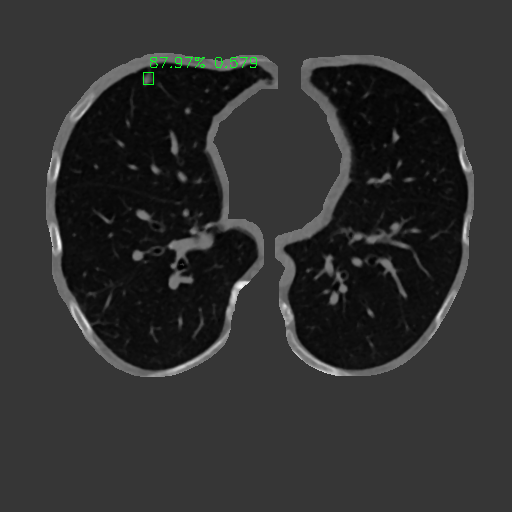

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = load_dataset('/content/drive/MyDrive/DeepTumour/training/test.txt')

def place_box(image, x1, y1, x2, y2, label, colour =(36,255,12)):
  im = cv2.rectangle(image,(int(x1), int(y1)), (int(x2), int(y2)) , colour, 1)

  cv2.putText(im, label, (int(x1)+5, int(y1)-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colour, 1)

  return im

for d in random.sample(dataset_dicts, 1):
    print(d)
    image = cv2.imread(d["file_name"])
    preds = make_prediction(image)
    print(preds)
    bestIOU = -124
    c = None

    i = 0
    for t in d["annotations"]:    
        print(f"Ground Truth: {t['bbox']} Category: {t['category_id']}")

    for p in preds:
      best_link = 0
      for t in d["annotations"]:    
        iou = bb_intersection_over_union(t['bbox'], p.bbox)
        if iou > best_link:
          best_link = iou

      label = f"{round(p.score*100, 2)}% {round(best_link, 4)}"
      c = (36,255,12)
      if iou <= 0:
        c = (12,36,255)
      place_box(image, p.bbox[0], p.bbox[1], p.bbox[2], p.bbox[3], label, c)

    # for p in preds:
    #   label = f"{round(p.score*100, 2)}%"
    #   image = place_box(image, p.bbox[0], p.bbox[1], p.bbox[2], p.bbox[3], label)

    cv2_imshow(image)
'/content/drive/My Drive/DeepTumour/pre-processing/data/Image/LIDC-IDRI-0420/LIDC-IDRI-0420_slice_82.png


In [ ]:
# Cat One Average Area: 749.844047579271
# Cat Two Average Area: 276.75159363751567
# Cat Three Average Area: 1729.7932098765423
class Prediction:
  def __init__(self, bboxandscore, predicted_by):
    self.bbox = bboxandscore[0]
    self.iou = 0
    self.predicted_by = predicted_by
    self.score = bboxandscore[1]

  def update_iou(self, iou):
    if iou > self.iou:
      self.iou = iou
      return True
    else:
      return False

  def __str__(self):
    return "[" + ", ".join(map(str, self.bbox)) + "] IoU: {:.4f}".format(self.iou)

  def __repr__(self):
    return "[" + ", ".join(map(str, self.bbox))+"] IoU: {:.4f}".format(self.iou)

class TrueTumour:
  def __init__(self, bbox, category):
    self.bbox = bbox
    self.category = category
    self.predictions = []

  def add_prediction(self, tumour):
    self.predictions.append(tumour)
  

def analyse_predictions(ground_truth, predictions):

  links = [TrueTumour(true['bbox'], true['category_id']) for true in ground_truth]
  false_positives = []
  for tumour in predictions:
    parent = None
    for i, truth in enumerate(links):
      iou = bb_intersection_over_union(truth.bbox, tumour.bbox)
      if tumour.update_iou(iou):
        parent = i

    if parent is not None:
      links[parent].add_prediction(tumour)
    else:
      false_positives.append(tumour)

  return links, false_positives
class TumourGroup:
  def __init__(self, main):
    self.main_predictor = main
    self.predictors = []
    self.ious = []


    self.x1 = self.main_predictor.bbox[0]
    self.y1 = self.main_predictor.bbox[1]
    self.x2 = self.main_predictor.bbox[2]
    self.y2 = self.main_predictor.bbox[3]

    self.predicted_by = self.main_predictor.predicted_by
    self.score = self.main_predictor.score

  def add_new(self, new):

    iou = bb_intersection_over_union(self.main_predictor.bbox, new.bbox)
    if iou > 0:
      self.predictors.append(new)
      self.ious.append(iou)

      self.x1 = min(self.x1, new.bbox[0])
      self.y1 = min(self.y1, new.bbox[1])
      self.x2 = min(self.x2, new.bbox[2])
      self.y2 = min(self.y2, new.bbox[3])

      if new.score > self.score:
        self.score = new.score
        self.predicted_by = new.predicted_by

      return True
    else:
      return False


  def get_prediction(self):
    if self.predicted_by == 1 and self.score <= 0.55 and len(self.predictors) == 0:
      # Probably a false positive
      print("Discarded")
      return None
    return Prediction(([self.x1, self.y1, self.x2, self.y2], self.score), self.predicted_by)

  def get_area(self):
    width = self.x2 - self.x1
    height = self.y2 - self.y1

    return width * height
  def __repr__(self):
    return f"I am a category {self.predicted_by} tumour with {self.score} probability and {len(self.predictors)} predictors"


def make_prediction(image):

    outputs = predictor(image)
    outputs2 = predictor2(image)
    outputs3 = predictor3(image)

    preds1 = outputs["instances"].pred_boxes.tensor.cpu().numpy()
    preds2 = outputs2["instances"].pred_boxes.tensor.cpu().numpy()
    preds3 = outputs3["instances"].pred_boxes.tensor.cpu().numpy()
    
    scores1 = outputs["instances"].scores.cpu().numpy()
    scores2 = outputs2["instances"].scores.cpu().numpy()
    scores3 = outputs3["instances"].scores.cpu().numpy()

    p1 = zip(preds1, scores1)
    p2 = zip(preds2, scores2)
    p3 = zip(preds3, scores3)

    all_predictions = [Prediction(t, 1) for t in p1] + [Prediction(t, 2) for t in p2] + [Prediction(t, 3) for t in p3]

    if len(all_predictions) == 0:
      return []
    i = -1

    tumours = []
    while True:
      tumours.append(TumourGroup(all_predictions.pop()))
      if len(all_predictions) <= 0:
        break
      i += 1
      for pred in all_predictions:
        if tumours[i].add_new(pred):
          all_predictions.remove(pred)

      if len(all_predictions) <= 0:
        break
    # print(tumours)
    t_list = [t.get_prediction() for t in tumours]
    return list(filter(None, t_list))







In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = load_dataset('/content/drive/MyDrive/DeepTumour/training/test.txt')

DEBUG = False


matrix = {
    0: {
        'true_positive': 0,
        'false_positive': 0,
        'false_negative': 0
    },
    1: {
        'true_positive': 0,
        'false_positive': 0,
        'false_negative': 0
    },
    2: {
        'true_positive': 0,
        'false_positive': 0,
        'false_negative': 0
    },
    3: {
        'true_positive': 0,
        'false_positive': 0,
        'false_negative': 0
    }
}


# limit = len(dataset_dicts)

total = 2698
count = 0


import time
images = []
for d in dataset_dicts[0:100]:
    image = cv2.imread(d["file_name"])
    images.append(image)
print(f"Starting inference on {len(images)} images.")
start_time = time.time()
for image in images:
  all_predictions = make_prediction(image)
print("--- %s seconds ---" % (time.time() - start_time))


for d in dataset_dicts[0:1]:
    image = cv2.imread(d["file_name"])

    all_predictions = make_prediction(image)

    links, false_positives = analyse_predictions(d["annotations"], all_predictions)
    
    tp_consensous = 0 

    for ground_truth in links:
      if len(ground_truth.predictions) > 0:
        if DEBUG:
          print(f"Category {ground_truth.category} tumour sucsesfuly detected! Best IoU of {sorted([p.iou for p in ground_truth.predictions])[-1]}!")
        matrix[ground_truth.category]['true_positive'] += 1
        count += 1
      else: 
        if DEBUG:
          print(f"False negative for a category {ground_truth.category} tumour.")
        matrix[ground_truth.category]['false_negative'] += 1
        count += 1

    for fp in false_positives:
        if DEBUG:
          print(f"Model {fp.predicted_by} detected a false positive. Score: {fp.score}")
        matrix[fp.predicted_by]['false_positive'] += 1

    print( f"{count}/{total}: {(count/total)*100}%")




print(matrix)
total_tp = matrix[0]['true_positive'] + matrix[1]['true_positive'] + matrix[2]['true_positive'] + matrix[3]['true_positive']
total_fp = matrix[0]['false_positive'] + matrix[1]['false_positive'] + matrix[2]['false_positive'] + matrix[3]['false_positive']
total_fn = matrix[0]['false_negative'] + matrix[1]['false_negative'] + matrix[2]['false_negative'] + matrix[3]['false_negative']

precision = total_tp / (total_tp + total_fp)
recall = total_tp / (total_tp + total_fn)
f1 = 2 * ((precision * recall) / (precision + recall))
print(f"\n\nTotal True Positives {total_tp}")
print(f"Total False Positives {total_fp}")
print(f"Total False Negatives {total_fn}")

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

print(f"{total_tp + total_fn} tumours analysed.")

# Cat One Average Area: 749.844047579271
# Cat Two Average Area: 276.75159363751567
# Cat Three Average Area: 1729.7932098765423

/content/drive/MyDrive/DeepTumour/training/test.txt
{0: 0, 1: 346, 2: 669, 3: 54}
1069 total tumours.




KeyboardInterrupt: ignored

In [ ]:
!nvidia-smi -L


GPU 0: Tesla T4 (UUID: GPU-24eb6518-a666-9ef6-0cee-b2fd7e993539)
